In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

import thanh as t
plt.style.use('seaborn')
%matplotlib inline

In [2]:
df = pd.read_csv('data/Census_Merged.csv', index_col =False)
df = df.dropna()
df = df.drop(df.columns.values[0], axis = 1)

C:\Users\nctha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Community Name,Total Population,Racial Demographics - Hispanic Proportion,Racial Demographics - Black Proportion,Racial Demographics - White Proportion,Racial Demographics - Asian Proportion,Racial Demographics - Other or Multiple Races Proportion
0,10778514.0,HZ544820,2016-12-08 17:23:00,079XX S MAY ST,0820,THEFT,$500 AND UNDER,APARTMENT,False,True,...,41.9,15528.0,74.0,Auburn Gresham,46817.0,0.02,0.96,0.01,0.0,0.01
1,11411914.0,JB390837,2018-08-12 22:00:00,013XX W 76TH ST,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,41.9,15528.0,74.0,Auburn Gresham,46817.0,0.02,0.96,0.01,0.0,0.01


### Types of crime in Chicago that are noticed in this project are:
 * <span style="color:blue"> ***THEFT*** </span>: Steal something which belongs to someone else.
 * <span style="color:blue"> ***BATTERY*** </span>: Cause physical harm to another person.
 * <span style="color:blue"> ***CRIMINAL*** </span>: Destroying or damaging property.
 * <span style="color:blue"> ***ASSAULT*** </span>: Threaten physical harm to another person.
 * <span style="color:blue"> ***DECEPTIVE*** </span>: Attempt to deceive or defraud a person or business. 
 * <span style="color:blue"> ***BURGLARY*** </span>: Breaking into someone's house with the intent of stealing.
 * <span style="color:blue"> ***ROBBERY*** </span>: Stealing from someone with threats of violence (e.g. mugging).

### Crime with more violence:
* <span style="color:blue"> ***BATTERY*** </span> 
* <span style="color:blue"> ***ASSAULT*** </span>
* <span style="color:blue"> ***ROBBERY*** </span>
* <span style="color:blue"> ***CRIMINAL SEXUAL ASSAULT*** </span>
* <span style="color:blue"> ***KIDNAPPING*** </span>
* <span style="color:blue"> ***HOMICIDE*** </span> : Homicide is the act of one human killing another
* <span style="color:blue"> ***ARSON*** </span> : The criminal act of deliberately setting fire to property.

In [4]:
violent_crime = df[df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]
nonviolent_crime = df[~df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]

### <span style="color:blue"> ***The plot below shows the "number of crimes respectively with their type".*** </span> 

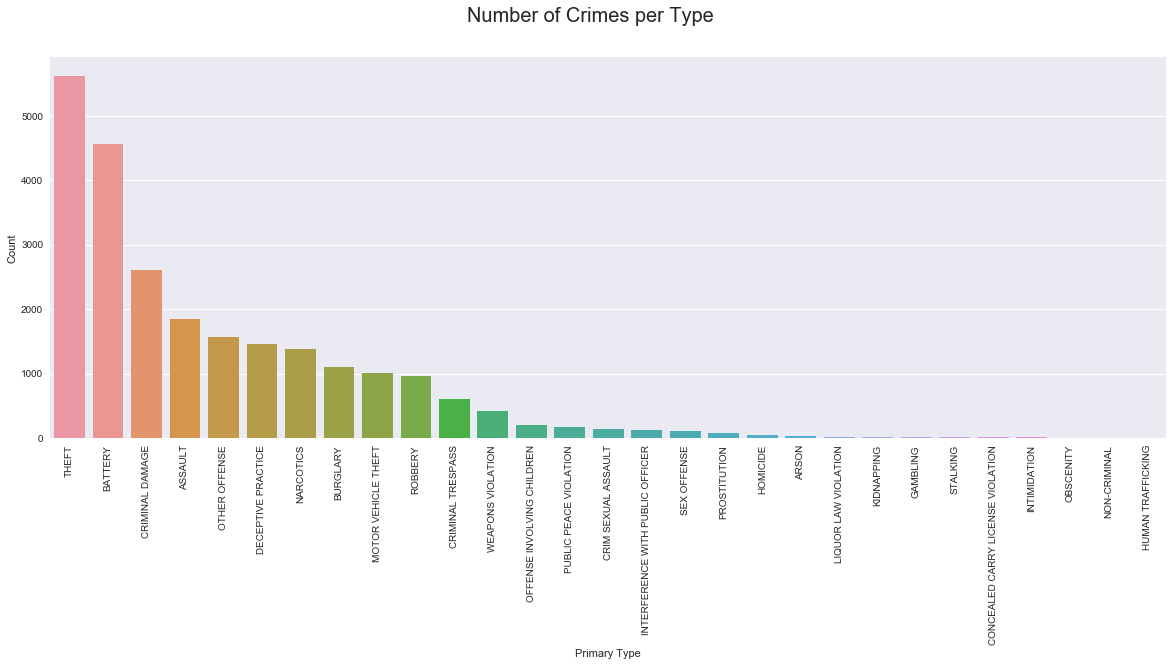

In [6]:
names = df['Primary Type'].value_counts().keys().tolist()
counts = df['Primary Type'].value_counts().tolist()
df_count = pd.DataFrame()
df_count['Primary Type'] = names
df_count['Count'] = counts
df_count.head(3)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
sns.barplot(y = df_count['Count'], x = df_count['Primary Type'], ax = axes)
axes.set_xlabel("Crime Count")
axes.set_xlabel("Primary Type")
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)
fig.suptitle('Number of Crimes per Type', fontsize=20)
plt.show()

## <span style="color:blue"> ***Problems and Challenges faced with label prediction.*** </span> 

A considerable amount of discrepancy can be seen in the above plot (*Number of crimes for each type*). 
Therefore, if an input vector is provided and any classification is to be done for predicting certain types of crime that could occur, it will become impossible because of following reasons:

1. There are 29 labels which makes classification of training sets difficult.This in turn would lead to prediction with low accuracy.

2. A big gap can be noticed amongst occurrences of different types of crime. This would lead the predicted outcome to be more leaned towards the labels(crimes) which account for majority of data. 



##  <span style="color:blue"> ***Dealing with problems and challenges.*** </span> 

1. **Reducing the number of Labels**:

    - The types of crime will be further divided into two subgroups(violent crimes and non-violent crimes). 
    - The classification of different types of crime will be done to determine the appropriate model for label prediction. This will be done for both the subgroups. However, it is clear that there are certain types of crime which account for low proportions of total number of crimes. Therefor we decide to remove all crime labels which having a proportion of less than 5 % in each respective subgroups.
    - *Violent Crimes* - The labels which will be used are: BATTERY(60%), ASSAULT(24%), ROBBERY(12%).
    - *Non-Violent Crimes* - The labels which will be used are: THEFT(34%), CRIMINAL DAMAGE(15%), OTHER OFFENSE(9%), DECEPTIVE PRACTICE(8%), NARCOTICS(8%), BURGLARY(6%), MOTOR VEHICLE THEFT(6%)
    
    
2. **Reducing the biased predictions which are witnessed due to certain labels having a majority of observations in the    data**:
    - 2.1 Before implementing "data-balancing" we will make use of "F1-score metric" to examine the performance of various classification models. Since, F1 score is more suitable for skewed data sets we will not be using accuracy. 
    - 2.2 Addition of weights such as class weights to create a bias towards minority classes will help in performing and assessing different classification models using both F1-score and accuracy. 
    - 2.3 Using SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority classes will help in performing and assessing different classification models using both F1-score and accuracy. 

# Label Prediction for violent crimes

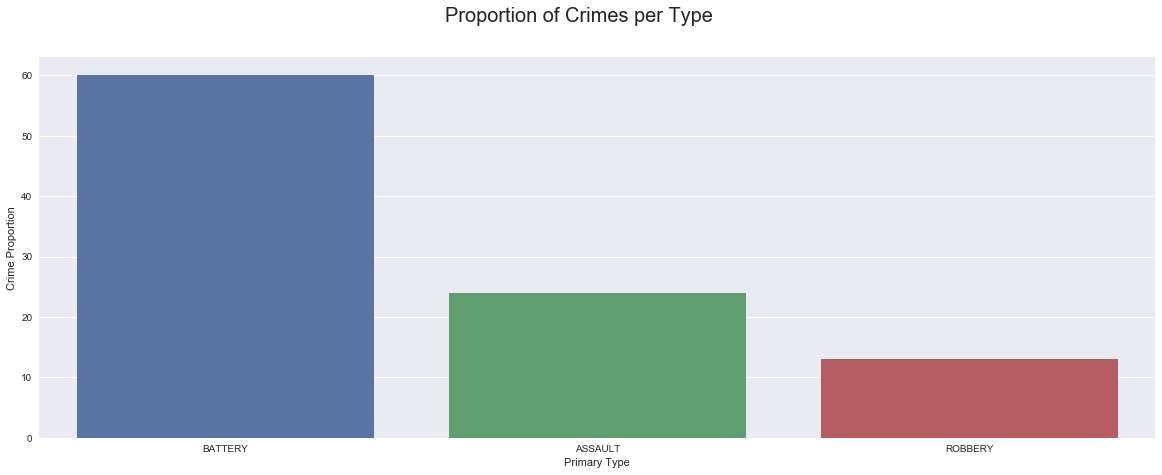

In [7]:
df_violent_count = t.crime_proximity(violent_crime, 'Primary Type', 5)
t.crime_proximity_bar(df_violent_count, 'Percentage')


In [8]:
violent_crime = violent_crime[violent_crime['Primary Type'].isin(list(df_violent_count['Primary Type']))]
target = 'Primary Type'
features = ['Arrest', 'Domestic', 'Community Area', 'Latitude', 'Longitude', 
            'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX','Racial Demographics - Hispanic Proportion',
       'Racial Demographics - Black Proportion',
       'Racial Demographics - White Proportion',
       'Racial Demographics - Asian Proportion',
       'Racial Demographics - Other or Multiple Races Proportion']

dummy = pd.get_dummies(violent_crime[features])
dummy.drop(columns=['Community Area'], inplace = True)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


X = dummy
#X = violent_crime[features]
y = violent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Number of training outcome labels:",len(y_train))

logi = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 10000)
logi.fit(X_train, y_train)

Number of training outcome labels: 5531


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

# Append rows in Empty Dataframe by adding dictionaries
scores = scores.append({'Model': 'Weighted Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

It is clear that using Logistic Regression, the F1-score for predicting labels is relatively low. Nonetheless, we are still able to see that this model do not overfit, since it's testing set's F1-score is marginally higher than it's traning F1 score. We will use this as a baseline perfomance metric to compare other different classifier against.

# Transform continuous variables into ordinal variables based on which quantiles it is depending on the distribution of the column values

In [11]:
for i, items in dummy.iteritems():
    dummy[i] = pd.qcut(dummy[i].rank(method='first'), 10, labels=False)
dummy.head(2)

,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Racial Demographics - Hispanic Proportion,Racial Demographics - Black Proportion,Racial Demographics - White Proportion,Racial Demographics - Asian Proportion,Racial Demographics - Other or Multiple Races Proportion,Arrest_False,Arrest_True,Domestic_False,Domestic_True
1,2,5,4,4,9,4,7,3,6,0,9,0,0,0,1,0,0,6
3,1,6,4,4,9,4,7,3,6,0,9,0,0,0,1,0,0,6


# Applying Nearest Neighbour SMOTE to re-balance dataset

In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1, sampling_strategy = 'not majority')
#sm = SMOTE(random_state=1, sampling_strategy = 'minority')
X = dummy
y = violent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

Number of training outcome labels: 10254


In [13]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [14]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [15]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [16]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Applying Borderline SMOTE re-balance dataset

In [17]:
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=1, sampling_strategy = 'not majority')
#sm = SMOTE(random_state=1, sampling_strategy = 'minority')
X = dummy
y = violent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

Number of training outcome labels: 10254


In [18]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [19]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [20]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [21]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Undersampling using Condensed Nearest Neighbors

In [22]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=1)

X = dummy
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


Number of training outcome labels: 2230


In [23]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [24]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [25]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [26]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Combine oversampling by creating Synthetic datapoints with undersampling by removing Tomek Links

In [27]:
from imblearn.combine import SMOTETomek
sm = SMOTETomek(random_state=1)
X = dummy
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))



Number of training outcome labels: 10218


In [28]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [29]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [30]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [31]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [32]:
stacked_scores = pd.melt(scores, id_vars=['Model']).sort_values(['variable','value'])

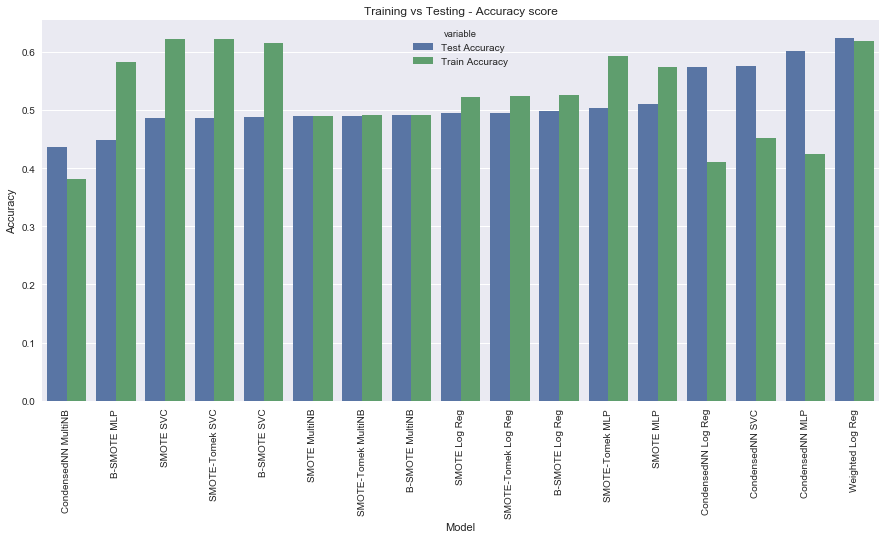

In [33]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## General comments on over-sampling techniques
Looking at the 2 oversampling methods, it is clear that all 3 classification models, apart from Multinomial NB, have a tendency to under-fit. This could be due to the models just "memorise" the labels rather than actually learning to predict the labels.

## General comments on under-sampling techniques
Looking at the undersampling, it is clear that all 3 classification models have a tendency to under-fit. This means that the models here perform rather poor on training data, and that its higher testing accuracy might be due to chance.

# Analysis of label prediction after using different re-sampling techniques on training data
In general, resampling algorithms depends very much on the quality of the dataset you have. If you have severe data imbalance, resampling algorithms may be ineffective in generating a high-quality dataset, despite their capability to balance out the dataset. 

This is largely due to the similarities between the two classes minority classes being very high (and hence the oversample resulting in low-quality repetitive data), despite them being acceptably close in terms of total occurrences' proportion. 

To determine that this is the case, we will try to train a classification model on the minority classes (which are not as strongly skewed towards any class as the dataset above) and check the results if the classification accuracy remains low despite the relatively balanced dataset.

# Minority Labels Analysis

In [34]:
minority = violent_crime[violent_crime['Primary Type'].isin(
    ['ROBBERY', 'ASSAULT'])]
label = minority['Primary Type']

In [35]:
minority  = pd.get_dummies(minority[features]).copy()
minority.drop(columns=['Community Area'], inplace = True)

In [36]:
for i, items in minority.iteritems():
    minority[i] = pd.qcut(minority[i].rank(method='first'), 10, labels=False)
X = minority
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))
minority_scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

Number of training outcome labels: 2710


In [37]:
logi.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [38]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [39]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [40]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [41]:
stacked_minority_scores = pd.melt(minority_scores, id_vars=['Model']).sort_values(['variable','value'])

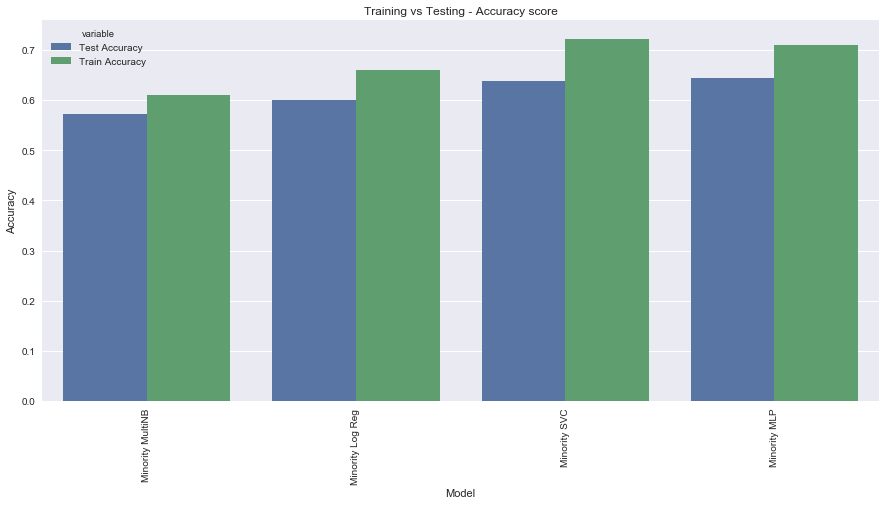

In [42]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_minority_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.show()

As suspected above, despite having a relatively "balanced" dataset, the models still perform poorly, even more so comparing to the logistic regression model with the original imbalanced dataset.

# Feature selection - Feature importance

C:\Users\nctha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.13350603 0.22902807 0.02386792 0.02411881 0.02729642 0.03022291
 0.03089802 0.0255571  0.02623602 0.02871654 0.02442009 0.02956325
 0.02341045 0.03539554 0.04423057 0.04353938 0.1274286  0.09256426]


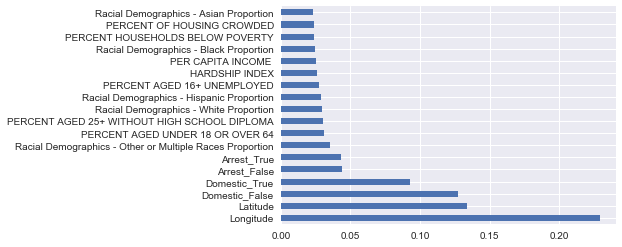

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

X = dummy
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
print(etc.feature_importances_)
feat_importances = pd.Series(etc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(len(X)).plot(kind='barh')
plt.show()

# Feature selection (top 5) without re-sampling

In [44]:
filtered = dummy[['Arrest_True', 'Latitude', 'Longitude', 'Domestic_False', 'Domestic_True']]
X = filtered
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

feature_score = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])
print("Number of training outcome labels:",len(y_train))

Number of training outcome labels: 5531


In [45]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [46]:
svm = SVC(gamma='auto', class_weight = 'balanced')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [47]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [48]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Feature selection (top 5) with under-sampling

In [49]:
X = filtered
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


Number of training outcome labels: 2222


In [50]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [51]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [52]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [53]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [54]:
stacked_feature_score = pd.melt(feature_score, id_vars=['Model']).sort_values(['variable','value'])

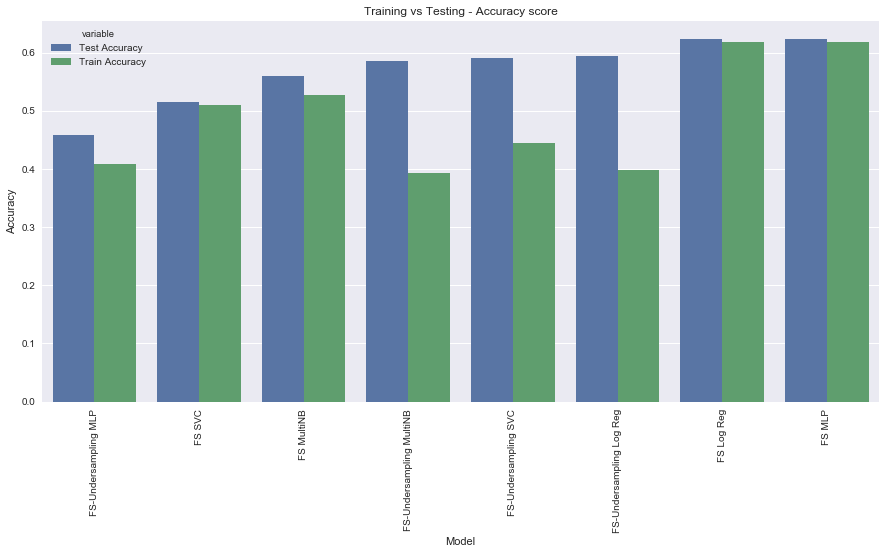

In [55]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_feature_score, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## Analysis on feature selection
Looking at the accuracy score, we can see that despite the performance of the 3 models still being quite poor, there were minor improvements comparing to using prediction with all predictors.

Especially for Feature selection without re-sampling, the performance of prediction on train and testing sets are very similar

# Non-violent crime

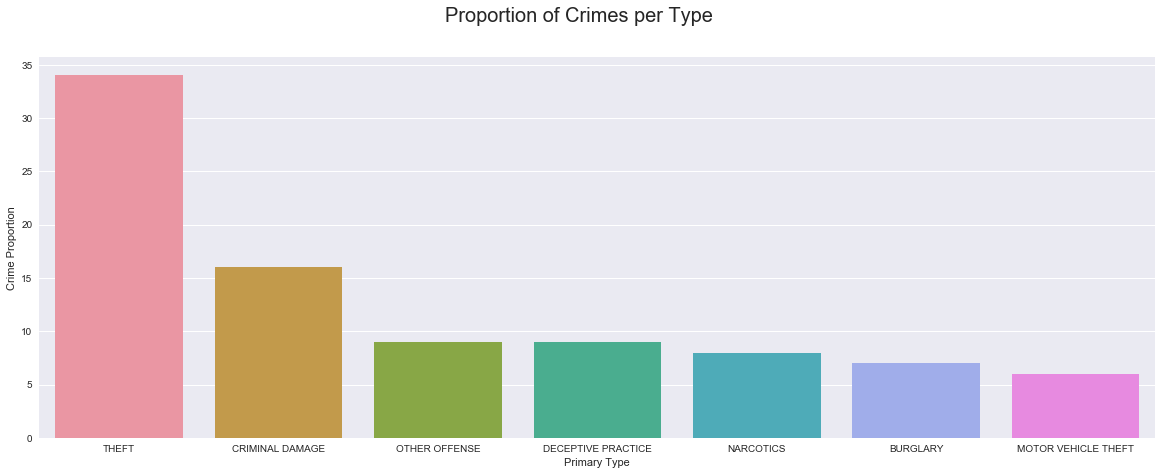

In [56]:
df_nonviolent_count = t.crime_proximity(nonviolent_crime, 'Primary Type', 5)
t.crime_proximity_bar(df_nonviolent_count, 'Percentage')

In [57]:
nonviolent_crime = nonviolent_crime[nonviolent_crime['Primary Type'].isin(list(df_nonviolent_count['Primary Type']))]
target = 'Primary Type'
features = ['Arrest', 'Domestic', 'Community Area', 'Latitude', 'Longitude', 
            'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX','Racial Demographics - Hispanic Proportion',
       'Racial Demographics - Black Proportion',
       'Racial Demographics - White Proportion',
       'Racial Demographics - Asian Proportion',
       'Racial Demographics - Other or Multiple Races Proportion']

dummy = pd.get_dummies(nonviolent_crime[features])
dummy.drop(columns=['Community Area'], inplace = True)

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


X = dummy
#X = violent_crime[features]
y = nonviolent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Number of training outcome labels:",len(y_train))
scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

Number of training outcome labels: 11061


In [59]:
logi = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 10000)
logi.fit(X_train, y_train)

scores = scores.append({'Model': 'Weighted Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

# Transform continuous variables into ordinal variables based on which quantiles it is depending on the distribution of the column values

In [60]:
for i, items in dummy.iteritems():
    dummy[i] = pd.qcut(dummy[i].rank(method='first'), 10, labels=False)
dummy.head(2)

,Latitude,Longitude,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Racial Demographics - Hispanic Proportion,Racial Demographics - Black Proportion,Racial Demographics - White Proportion,Racial Demographics - Asian Proportion,Racial Demographics - Other or Multiple Races Proportion,Arrest_False,Arrest_True,Domestic_False,Domestic_True
0,1,5,5,5,9,5,8,2,7,0,9,0,0,0,1,0,0,9
2,1,5,5,5,9,5,8,2,7,0,9,0,0,0,1,0,0,0


# Applying Nearest Neighbour SMOTE to re-balance dataset

In [61]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1, sampling_strategy = 'not majority')
#sm = SMOTE(random_state=1, sampling_strategy = 'minority')
X = dummy
y = nonviolent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

Number of training outcome labels: 29274


In [62]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [63]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [64]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [65]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Applying Borderline SMOTE re-balance dataset

In [66]:
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=1, sampling_strategy = 'not majority')
#sm = SMOTE(random_state=1, sampling_strategy = 'minority')
X = dummy
y = nonviolent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

Number of training outcome labels: 29274


In [67]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [68]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [69]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [70]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Undersampling using Condensed Nearest Neighbors

In [71]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=1)

X = dummy
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


Number of training outcome labels: 5050


In [72]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [73]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [74]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [75]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Combine oversampling by creating Synthetic datapoints with undersampling by removing Tomek Links

In [76]:
from imblearn.combine import SMOTETomek
sm = SMOTETomek(random_state=1)
X = dummy
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))



Number of training outcome labels: 29178


In [77]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [78]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [79]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [80]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [81]:
stacked_scores = pd.melt(scores, id_vars=['Model']).sort_values(['variable','value'])

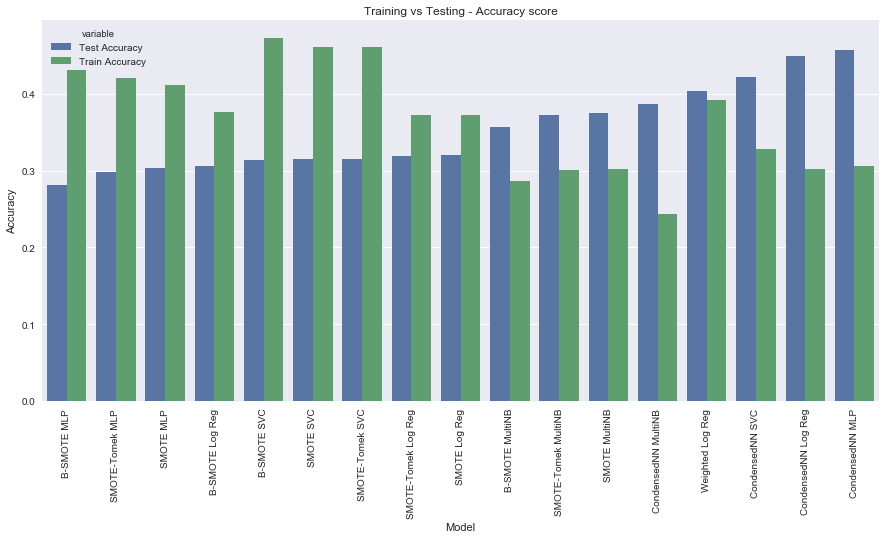

In [82]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## General comments on over-sampling techniques
Looking at the 2 oversampling methods, it is clear that all 3 classification models, apart from Multinomial NB, have a tendency to under-fit. This could be due to the models just "memorise" the labels rather than actually learning to predict the labels.

## General comments on under-sampling techniques
Looking at the undersampling, it is clear that all 4 classification models have a tendency to under-fit. This means that the models here perform rather poor on training data, and that its higher testing accuracy might be due to chance.

# Analysis of label prediction after using different re-sampling techniques on training data

Similar to prediction for violent crime, the model that showed the highest consistency (accuracy similarity) is weighted multinomial logistic regresion. However, all tested models performed worse in prediction for non-violent crime in comparison with prediction for violent crime, due to non-violent crime have more labels (prediction outcomes).

In general, resampling algorithms depends very much on the quality of the dataset you have. If you have severe data imbalance, resampling algorithms may be ineffective in generating a high-quality dataset, despite their capability to balance out the dataset. 

This is largely due to the similarities between the two classes minority classes being very high (and hence the oversample resulting in low-quality repetitive data), despite them being acceptably close in terms of total occurrences' proportion. 

To determine that this is the case, we will try to train a classification model on the minority classes (which are not as strongly skewed towards any class as the dataset above) and check the results if the classification accuracy remains low despite the relatively balanced dataset.

# Minority Labels Analysis

In [83]:
minority = nonviolent_crime[~nonviolent_crime['Primary Type'].isin(
    ['THEFT'])]
label = minority['Primary Type']

In [84]:
minority  = pd.get_dummies(minority[features]).copy()
minority.drop(columns=['Community Area'], inplace = True)

In [85]:
for i, items in minority.iteritems():
    minority[i] = pd.qcut(minority[i].rank(method='first'), 10, labels=False)
X = minority
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))
minority_scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

Number of training outcome labels: 11852


In [86]:
logi.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [87]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [88]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [89]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [90]:
stacked_minority_scores = pd.melt(minority_scores, id_vars=['Model']).sort_values(['variable','value'])

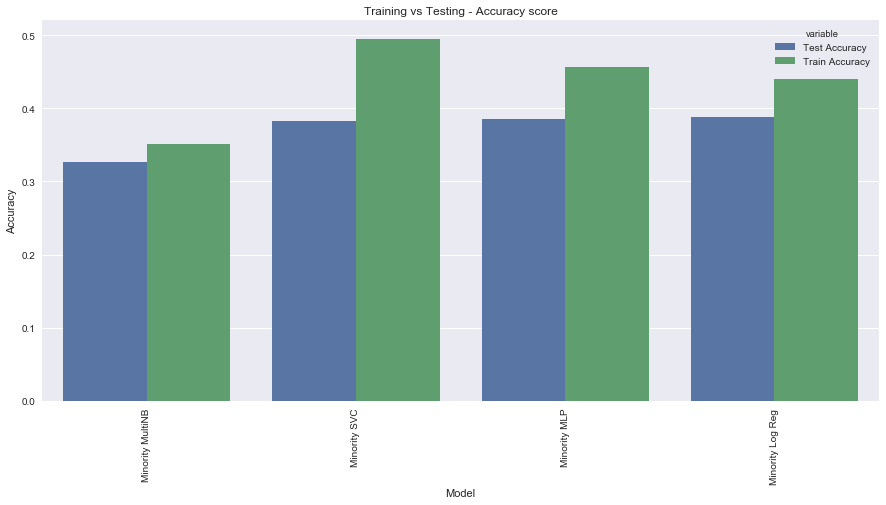

In [91]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_minority_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.show()

As suspected above, despite having a relatively "balanced" dataset, the models still perform poorly, even more so comparing to the logistic regression model with the original imbalanced dataset.

# Feature selection - Feature importance

C:\Users\nctha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11603876 0.1857961  0.0264372  0.03076655 0.02570209 0.02894908
 0.01877738 0.03377011 0.03524576 0.02047657 0.02540383 0.03716021
 0.02193425 0.01972226 0.13463389 0.11259283 0.0572446  0.06934853]


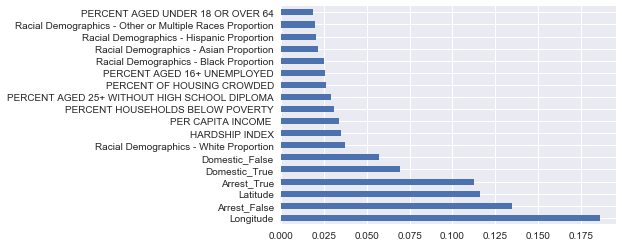

In [92]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

X = dummy
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
print(etc.feature_importances_)
feat_importances = pd.Series(etc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(len(X)).plot(kind='barh')
plt.show()

# Feature selection (top 5) without re-sampling

In [93]:
filtered = dummy[['Arrest_True', 'Arrest_False', 'Latitude', 'Longitude', 'Domestic_True']]
X = filtered
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

feature_score = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])
print("Number of training outcome labels:",len(y_train))

Number of training outcome labels: 11061


In [94]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [95]:
svm = SVC(gamma='auto', class_weight = 'balanced')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [96]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [97]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Feature selection with under-sampling

In [98]:
X = filtered
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


Number of training outcome labels: 5112


In [99]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [100]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [101]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [102]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [103]:
stacked_feature_score = pd.melt(feature_score, id_vars=['Model']).sort_values(['variable','value'])

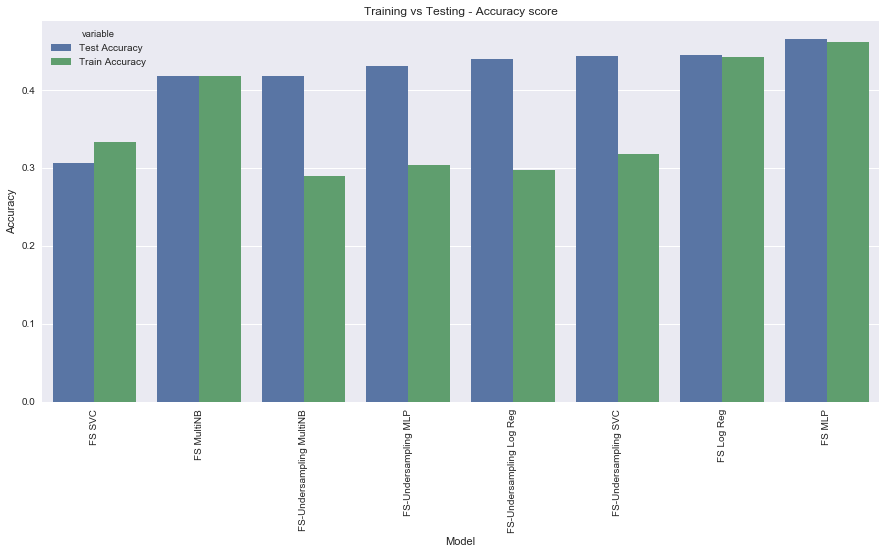

In [104]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_feature_score, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## Analysis on feature selection
Looking at the accuracy score, we can see that, apart from Support Vector Machine,  the 3 models are performing consistently despite their performance being quite poor. There are no signs of underfitting or overfitting, however, the dataset is still very much imbalanced.

On the other hand, re-sampling the dataset again results in poorer performance, indicating the "low-quality" of the training and test data.

# Some distribution plot

# Percentage of Arrest for each crime sub-group

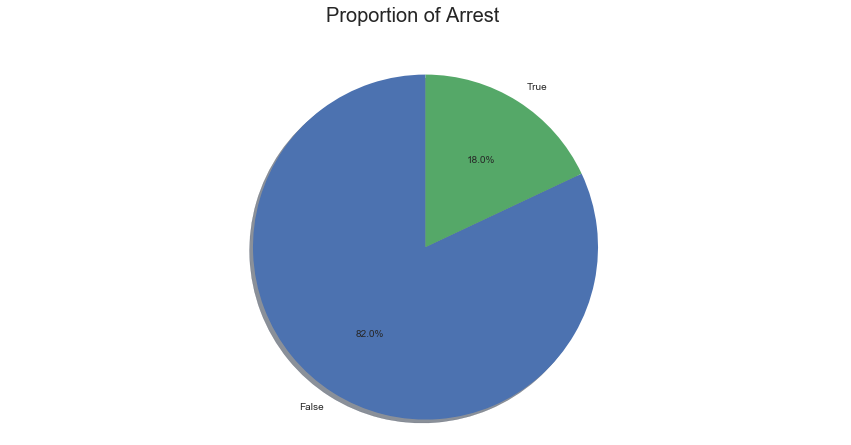

In [105]:
df_nonviolent_arrest = t.crime_proximity(nonviolent_crime, 'Arrest', 0)
t.pie(df_nonviolent_arrest, 'Percentage')

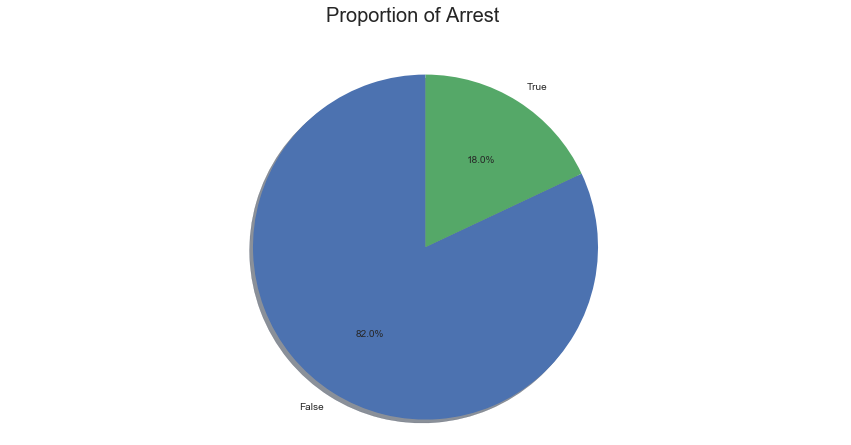

In [106]:
df_violent_arrest = t.crime_proximity(violent_crime, 'Arrest', 0)
t.pie(df_nonviolent_arrest, 'Percentage')

### INFERENCES:
A very small percentage of arrest in the 2 categories can be noticed above, and are similar enough. This indicates that there is not a certain emphasis of the police force on solving either sub-groups of crime. 

The generally low arrest rate could be due to lack of funding for law enforcement, which renders the police force unable to resolve so many crimes.



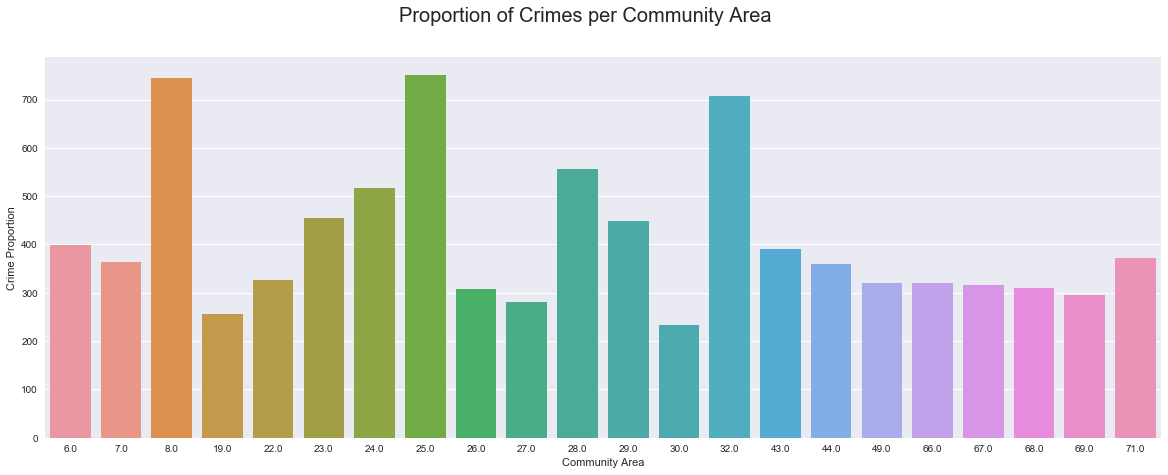

In [107]:
df_comm_area_count = t.crime_proximity(nonviolent_crime, 'Community Area', 1.5)
t.community_proximity_bar(df_comm_area_count, 'Count')